# Przygotowanie

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install shap
!pip install SAlib
!pip install sklearn-relief

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 575 kB 15.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 758 kB 13.2 MB/s 
     |████████████████████████████████| 132 kB 43.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# importy ogólne
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from timeit import default_timer as timer
from IPython.display import clear_output
from IPython.display import display, HTML
import pickle

# importy do modeli klasyfikacji
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression

# importy do sieci neuronowych keras
import tensorflow
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler

# insterpretacja istotności
import shap

# Analiza danych

In [4]:
airfoil_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DataSets/airfoil_self_noise.dat', sep='\s+', header=None )
airfoil_data.columns = [ 'frequency', 'angle' ,'length', 'velocity', 'thickness', 'pressure']

print( airfoil_data.info() )
print( airfoil_data.head() )

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1503 entries, 0 to 1502
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   frequency  1503 non-null   int64  
 1   angle      1503 non-null   float64
 2   length     1503 non-null   float64
 3   velocity   1503 non-null   float64
 4   thickness  1503 non-null   float64
 5   pressure   1503 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 70.6 KB
None
   frequency  angle  length  velocity  thickness  pressure
0        800    0.0  0.3048      71.3   0.002663   126.201
1       1000    0.0  0.3048      71.3   0.002663   125.201
2       1250    0.0  0.3048      71.3   0.002663   125.951
3       1600    0.0  0.3048      71.3   0.002663   127.591
4       2000    0.0  0.3048      71.3   0.002663   127.461


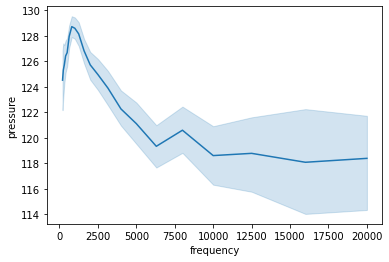

In [5]:
sns.lineplot(data=airfoil_data, x='frequency', y='pressure')

In [6]:
sns.lineplot(data=airfoil_data, x='angle', y='pressure')

In [7]:
sns.lineplot(data=airfoil_data, x='length', y='pressure')

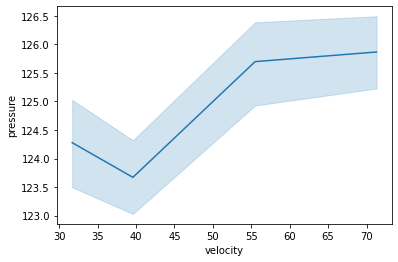

In [8]:
sns.lineplot(data=airfoil_data, x='velocity', y='pressure')

In [9]:
sns.lineplot(data=airfoil_data, x='thickness', y='pressure')

In [10]:
print( airfoil_data['pressure'].describe() )
sns.histplot(data=airfoil_data, x='pressure', bins=30)

count    1503.000000
mean      124.835943
std         6.898657
min       103.380000
25%       120.191000
50%       125.721000
75%       129.995500
max       140.987000
Name: pressure, dtype: float64


In [11]:
x_train, x_test, y_train, y_test = train_test_split( airfoil_data.drop('pressure', axis=1), airfoil_data['pressure'], test_size=0.3)

scaler = MinMaxScaler()
scaler.fit(x_train)
x_train = pd.DataFrame(scaler.transform(x_train), columns=x_train.columns)
x_test = pd.DataFrame(scaler.transform(x_test), columns=x_train.columns)

print( len(x_test) )
print( len(y_test) )
print( f' sum {y_test.isna().sum()}' )

test_sorted = x_test.copy()
test_sorted['pressure'] = y_test.copy().reset_index().drop('index', axis=1)
test_sorted = test_sorted.sort_values('pressure').reset_index().drop('index', axis=1)
print(test_sorted.head())
print(test_sorted.tail())

451
451
 sum 0
   frequency     angle    length  velocity  thickness  pressure
0   0.308081  0.702703  0.272727  0.199495   0.904111   104.204
1   0.148990  0.567568  0.454545  0.199495   1.000000   106.260
2   0.308081  0.554054  0.272727  0.199495   0.696874   107.985
3   0.191919  0.567568  0.454545  1.000000   0.825973   108.034
4   0.308081  0.693694  0.090909  0.000000   0.492748   108.185
     frequency     angle    length  velocity  thickness  pressure
446   0.053030  0.301802  0.272727       1.0   0.075541   137.658
447   0.010101  0.400901  0.272727       1.0   0.170798   138.123
448   0.021717  0.400901  0.272727       1.0   0.170798   138.423
449   0.000000  0.328829  0.727273       1.0   0.173067   138.758
450   0.010101  0.328829  0.727273       1.0   0.173067   139.438


# Model drzewa decyzyjnego

2.3955423907537106


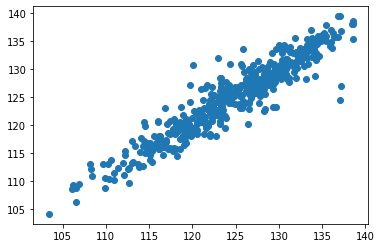

In [ ]:
dtree_model = DecisionTreeRegressor()
dtree_model.fit(x_train, y_train)

y_pred = dtree_model.predict(x_test)

print( np.sqrt(mean_squared_error(y_test, y_pred)) )
plt.scatter(y_test, y_pred)

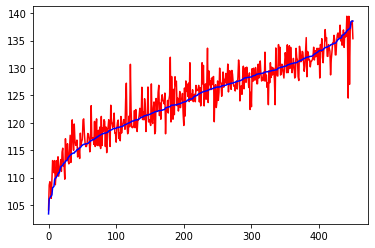

In [ ]:
y_pred = dtree_model.predict(test_sorted.drop('pressure', axis=1))
plt.plot( test_sorted.index, y_pred, color='red' )
plt.plot( test_sorted.index, test_sorted['pressure'], color='blue')

In [ ]:
pickle.dump(dtree_model, open('/content/drive/MyDrive/Colab Notebooks/models/AirModels/QMNIST_DTREE.sav', 'wb'))

# Model randomowych lasów

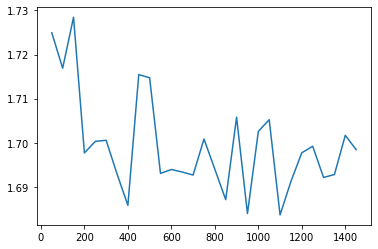

In [ ]:
amounts = [ i*50 for i in range(1,30) ]
rmse = []

for size in amounts:
  rforest = RandomForestRegressor(n_estimators=size)
  rforest.fit(x_train, y_train)
  y_pred = rforest.predict(x_test)
  rmse.append( np.sqrt(mean_squared_error(y_test, y_pred)) )

plt.plot(amounts, rmse)

1.6880716727641878


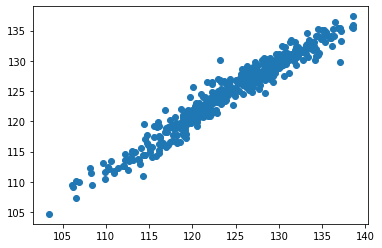

In [ ]:
rforest_model = RandomForestRegressor(n_estimators = 800)
rforest_model.fit(x_train, y_train)

y_pred = rforest_model.predict(x_test)

print( np.sqrt(mean_squared_error(y_test, y_pred)) )
plt.scatter(y_test, y_pred)

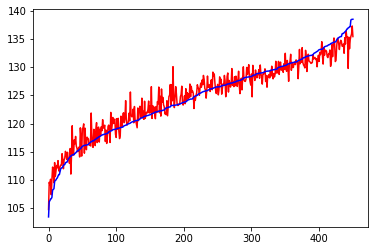

In [ ]:
y_pred = rforest_model.predict(test_sorted.drop('pressure', axis=1))
plt.plot( test_sorted.index, y_pred, color='red' )
plt.plot( test_sorted.index, test_sorted['pressure'], color='blue')

In [ ]:
pickle.dump(rforest_model, open('/content/drive/MyDrive/Colab Notebooks/models/AirModels/QMNIST_RFOREST.sav', 'wb'))

# Model MLP

In [ ]:
mlp_model = Sequential()
mlp_model.add( Dense(15, input_dim=5, activation='relu') )
mlp_model.add( Dense(10, activation='linear') )
mlp_model.add( Dense(10, activation='linear') )
mlp_model.add( Dense(1, activation='relu') )

mlp_model.compile(loss='mse', optimizer='adam')
stop_early = EarlyStopping(monitor='val_loss', patience=200, mode='min')

history = mlp_model.fit( x_train, y_train, verbose=1, epochs=1000, batch_size=32, validation_data=[x_test, y_test], callbacks=[stop_early] )

Epoch 1/1000
33/33 [==============================] - 1s 7ms/step - loss: 15591.8857 - val_loss: 15523.9482
Epoch 2/1000
33/33 [==============================] - 0s 3ms/step - loss: 15349.9902 - val_loss: 15148.9004
Epoch 3/1000
33/33 [==============================] - 0s 3ms/step - loss: 14754.6621 - val_loss: 14242.5176
Epoch 4/1000
33/33 [==============================] - 0s 3ms/step - loss: 13312.9004 - val_loss: 12081.7217
Epoch 5/1000
33/33 [==============================] - 0s 3ms/step - loss: 10200.4980 - val_loss: 7925.7012
Epoch 6/1000
33/33 [==============================] - 0s 3ms/step - loss: 5421.6758 - val_loss: 2979.1145
Epoch 7/1000
33/33 [==============================] - 0s 3ms/step - loss: 1656.0623 - val_loss: 894.2169
Epoch 8/1000
33/33 [==============================] - 0s 3ms/step - loss: 833.7393 - val_loss: 782.5696
Epoch 9/1000
33/33 [==============================] - 0s 3ms/step - loss: 770.8077 - val_loss: 734.8735
Epoch 10/1000
33/33 [=====================

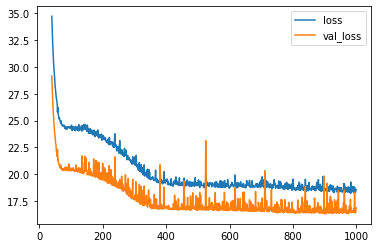

In [ ]:
pd.DataFrame( history.history ).iloc[40:].plot()

In [ ]:
y_pred = mlp_model.predict(x_test)

print( np.sqrt(mean_squared_error(y_test, y_pred)) )

15/15 [==============================] - 0s 1ms/step
4.111168924992501


15/15 [==============================] - 0s 1ms/step


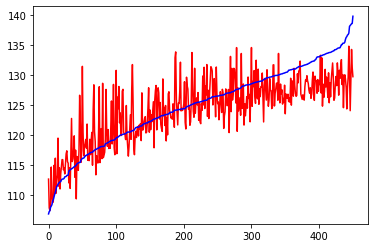

In [ ]:
y_pred = mlp_model.predict(test_sorted.drop('pressure', axis=1))
plt.plot( test_sorted.index, y_pred, color='red' )
plt.plot( test_sorted.index, test_sorted['pressure'], color='blue')

In [ ]:
mlp_model.save('/content/drive/MyDrive/Colab Notebooks/models/AirModels/AIR_MLP')

# Model SVM

In [ ]:
'''
grid_params = {
    'C': [0.1, 1, 100, 1000],
    'epsilon': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10],
    'gamma': [0.0001, 0.001, 0.005, 0.1, 1, 3, 5],
    'kernel': ['rbf', 'poly']
    }
grid = GridSearchCV(SVR(), param_grid=grid_params, verbose=1)
grid.fit(x_train, y_train)
'''

"\ngrid_params = {\n    'C': [0.1, 1, 100, 1000],\n    'epsilon': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10],\n    'gamma': [0.0001, 0.001, 0.005, 0.1, 1, 3, 5],\n    'kernel': ['rbf', 'poly']\n    }\ngrid = GridSearchCV(SVR(), param_grid=grid_params, verbose=1)\ngrid.fit(x_train, y_train)\n"

In [ ]:
'''
params = grid.best_params_
print(params)
svm_model = SVR( C=params['C'], epsilon=params['epsilon'], gamma=params['gamma'], kernel=params['kernel'] )
svm_model.fit(x_train, y_train)

y_pred = svm_model.predict(x_test)
print( np.sqrt(mean_squared_error(y_test, y_pred)) )
'''
best_params = {'C': 1000, 'epsilon': 1, 'gamma': 5, 'kernel': 'rbf'}

"\nparams = grid.best_params_\nprint(params)\nsvm_model = SVR( C=params['C'], epsilon=params['epsilon'], gamma=params['gamma'], kernel=params['kernel'] )\nsvm_model.fit(x_train, y_train)\n\ny_pred = svm_model.predict(x_test)\nprint( np.sqrt(mean_squared_error(y_test, y_pred)) )\n"

In [ ]:
svm_model = SVR( **best_params )
svm_model.fit(x_train.values, y_train.values)

SVR(C=1000, epsilon=1, gamma=5)

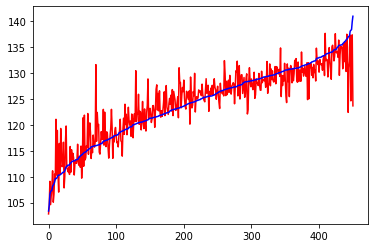

In [ ]:
y_pred = svm_model.predict(test_sorted.drop('pressure', axis=1).values)
plt.plot( test_sorted.index, y_pred, color='red' )
plt.plot( test_sorted.index, test_sorted['pressure'], color='blue')

In [ ]:
pickle.dump(svm_model, open('/content/drive/MyDrive/Colab Notebooks/models/AirModels/QMNIST_SVM.sav', 'wb'))

# Analiza istotności

In [12]:
# próbka danych dla anlizy shap
#Ksamples = shap.sample(x_train, 100)
#pickle.dump(Ksamples, open('/content/drive/MyDrive/Colab Notebooks/models/AirModels/Ksamples.sav', 'wb'))
Ksamples = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/models/AirModels/Ksamples.sav', 'rb'))

# biblioteki dla analizy wrażliwości
from SALib.analyze import morris
from SALib.analyze import sobol 
from SALib.sample import saltelli
import tensorflow as tf
import math


# określenie problemu dla analizy wrażliwości
problem = {
    'num_vars' : 5,
    'names' : list(x_train.columns),
    'bounds' : [
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1]
    ]
}

# wyprodukowane dane do analizy wrażliwści
#param_values = saltelli.sample(problem, 1024)
#pickle.dump(param_values, open('/content/drive/MyDrive/Colab Notebooks/models/AirModels/param_values.sav', 'wb'))
param_values = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/models/AirModels/param_values.sav', 'rb'))

# funkcja resetująca wagi modelu mlp na losowe wartości
def reinitialize(model):
    for l in model.layers:
        if hasattr(l,"kernel_initializer"):
            l.kernel.assign(l.kernel_initializer(tf.shape(l.kernel)))
        if hasattr(l,"bias_initializer"):
            l.bias.assign(l.bias_initializer(tf.shape(l.bias)))
        if hasattr(l,"recurrent_initializer"):
            l.recurrent_kernel.assign(l.recurrent_initializer(tf.shape(l.recurrent_kernel)))


def evaluate_models(features, models, params_for_model_fitting = {}, model_builder=None, amounts=10) -> None:
  '''
  funkcja mająca na celu wytrenować kolejny model z listy
  używając co iteracje nowego modelu i pomniejszonej liczby atrybutów.
  Na sam koniec wyrysowując dopasowanie modelu i 
  wypisując sqrt(mse) oraz mae
  '''

  # zbiór danych do odrzucania najmniej znaczącyh
  relief_x_train = x_train
  relief_x_test = x_test
  relief_test_sorted = test_sorted
  model_avg_scores = []
  all_scores = []

  fig, axes = plt.subplots( len(features), figsize=(14, 25) )

  for i, ax in enumerate(axes):
    # usunięcie kolejnego atrybutu
    if( i > 0 ):
      relief_x_train = relief_x_train.drop( features.index[i-1], axis=1 )
      relief_x_test = relief_x_test.drop( features.index[i-1], axis=1 )
      relief_test_sorted = relief_test_sorted.drop( features.index[i-1], axis=1 )

    # wytrenowanie modelu 10-krotnie i zebranie wartości błędu
    scores = []
    best_score = math.inf
    best_model = None
    best_weights_for_mlp = None
    threshold = 70.0

    for dummie in range(amounts):
      print(f'Uczę {dummie}-ty model dla {len(relief_x_train.columns.values)} atrybutów')
      clear_output(wait=True)
      met_threshold = False
      while ( not met_threshold ):
        if (model_builder):
          models[i] = model_builder()
          models[i].fit(relief_x_train, y_train)
        else:
          reinitialize(models[i])
          models[i].fit(relief_x_train, y_train, **params_for_model_fitting)
        y_pred = models[i].predict(relief_x_test)
        score = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)
        
        if ( score < best_score ):
          best_score = score
          if(model_builder):
            best_model = models[i]
          else:
            best_weights_for_mlp = models[i].get_weights()
        if( score < threshold ):
          met_threshold = True
          mae = mean_absolute_error(y_test, y_pred)
          scores.append( [score, mae] )
          #print( f'bez powtorki: {score}')
        else:
          #print( f'powtorka: {score}')
          pass

    model_avg_scores.append( np.mean(np.array(scores), axis=0) )
    all_scores.append(scores)

    if(model_builder):
      models[i] = best_model
    else:
      models[i].set_weights(best_weights_for_mlp)

    y_pred = models[i].predict(relief_x_test)
    # napis z metrykami
    text = f'rmse: {np.sqrt(mean_squared_error(y_test, y_pred)):0.4f}\nmae: {mean_absolute_error(y_test, y_pred):0.4f}'

    y_pred = models[i].predict(relief_test_sorted.drop('pressure', axis=1))
    ax.set_title( f'Wykres dopasowania\n{relief_x_train.columns.values}' )
    ax.plot( test_sorted.index, y_pred, color='blue', alpha=0.7 )
    ax.plot( test_sorted.index, test_sorted['pressure'], color='red')
    ax.text( 0.5, 0.2, text, transform=ax.transAxes, size=15,)

  print( "########## AVG SCORES ########")
  for avg_s in model_avg_scores:
    print( f'avg rmse: {avg_s[0]:7.3f} | mae: {avg_s[1]:7.3f} ' )
  print( "########## AVG SCORES ########")
  print( "########## ALL SCORES ########")
  for scores in all_scores:
    print( scores )
  print( "########## ALL SCORES ########")
  

# klasy zwracające instancje modelów 
class dtree_builder:
  def __call__(self):
    return DecisionTreeRegressor()

class rforest_builder:
  def __call__(self):
    return RandomForestRegressor(n_estimators=800)

class svm_builder:
  def __call__(self):
    return SVR(C=1000, epsilon=1, gamma=5, kernel='rbf')

stop_early = EarlyStopping(monitor='loss', patience=200, mode='min')
params_for_model_fitting = {'verbose':0, 'epochs':1000, 'batch_size':32, 'callbacks':[stop_early] }

attributes_dict = {}
for i, attr in enumerate(x_train.columns.values):
  attributes_dict[attr] = str(i)
  print(f'{attr} : {i}')


dtree_model = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/models/AirModels/AIR_DTREE.sav', 'rb'))
rforest_model = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/models/AirModels/AIR_RFOREST.sav', 'rb'))
svm_model = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/models/AirModels/AIR_SVM.sav', 'rb'))
mlp_model = keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/models/AirModels/AIR_MLP')

frequency : 0
angle : 1
length : 2
velocity : 3
thickness : 4


# Analiza RReliefF

In [ ]:
from sklearn_relief import RReliefF

rel = RReliefF(n_features=20, n_iterations=200)
rel.fit( x_train.values, y_train.values )

RReliefF()

Text(0.5, 1.0, 'Wartości wag dla atrybutów')

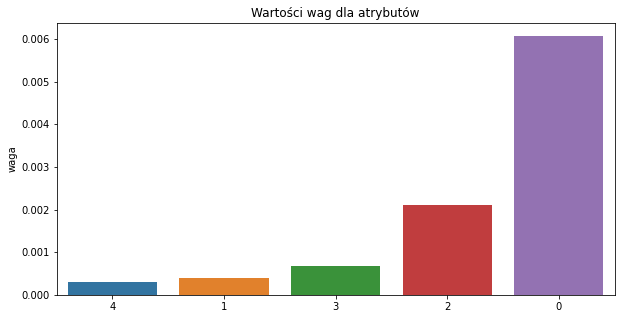

In [ ]:
features_relief = np.abs(rel.w_)
x_columns = x_train.columns

fig, ax = plt.subplots(figsize=(10, 5))
features_relief = pd.DataFrame(features_relief.reshape(-1, 1), index=x_columns, columns=['waga'])
features_relief.sort_values('waga', ascending=True, inplace=True)
pickle.dump(features_relief, open('/content/drive/MyDrive/Colab Notebooks/models/AirModels/features_r.sav', 'wb'))
attr_nums = [attributes_dict[att] for att in features_relief.index ]
sns.barplot(data=features_relief, x=attr_nums, y='waga')

'''
for i, p in enumerate(ax.patches):
    h, w, x = p.get_height(), p.get_width(), p.get_x()
    xy = (x + w / 2., h+0.00005)
    value = features_relief.iloc[i].values[0]
    text = f'{value:0.2e}'
    ax.annotate(s=text, xy=xy, ha='center', va='center')
'''

ax.set_title('Wartości wag dla atrybutów')

Modele drzewa decyzyjnego

########## AVG SCORES ########
avg rmse:   2.935 | mae:   2.075 
avg rmse:   2.895 | mae:   2.089 
avg rmse:   6.585 | mae:   5.191 
avg rmse:   5.527 | mae:   4.402 
avg rmse:   6.396 | mae:   4.995 
########## AVG SCORES ########


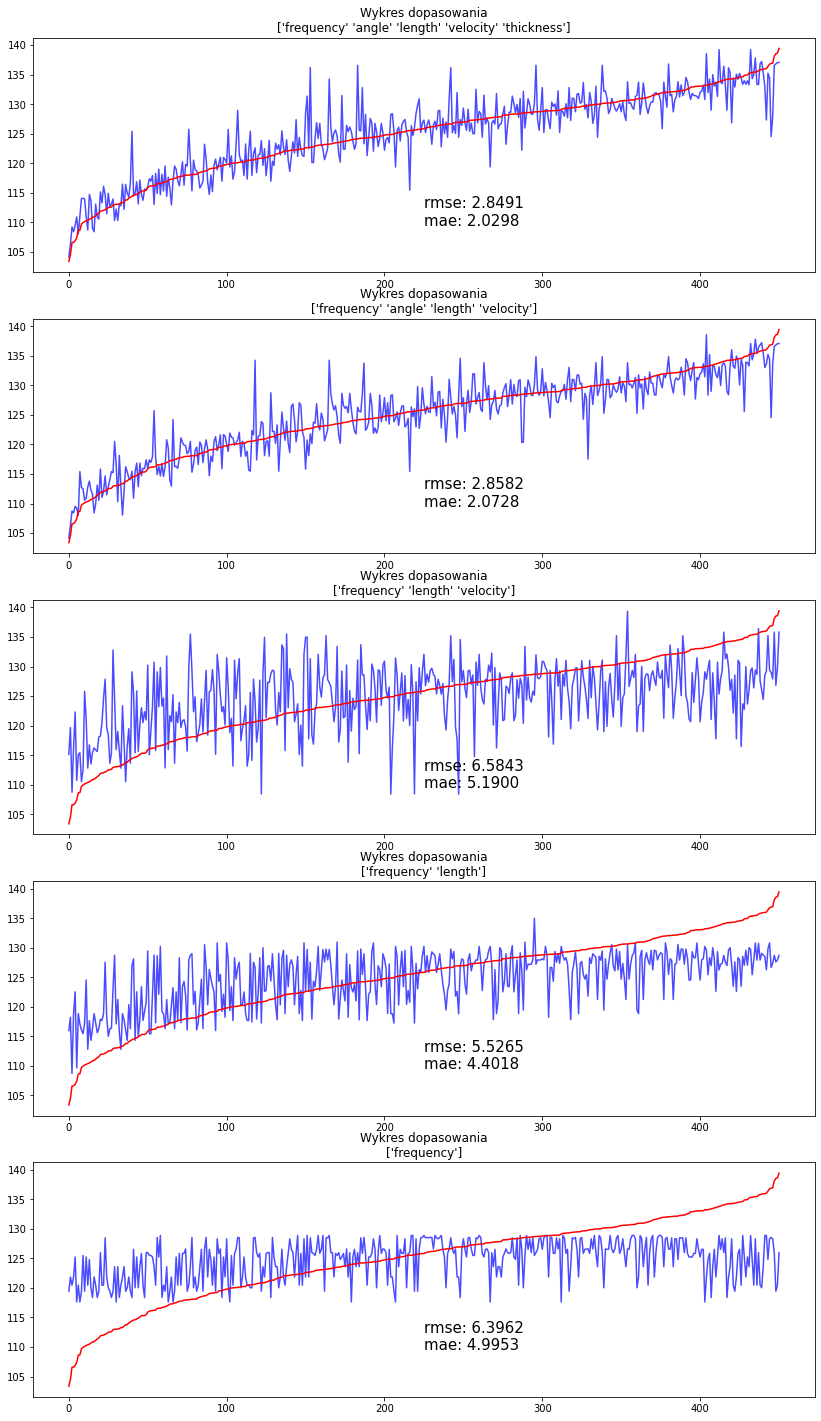

In [ ]:
dtree_models = []
for i in range(len(features_relief)):
  dtree_models.append( DecisionTreeRegressor() )

evaluate_models(features_relief, dtree_models, model_builder=dtree_builder(), amounts=10)

Modele randomowych lasów

########## AVG SCORES ########
avg rmse:   1.906 | mae:   1.342 
avg rmse:   2.155 | mae:   1.494 
avg rmse:   6.138 | mae:   4.894 
avg rmse:   5.523 | mae:   4.402 
avg rmse:   6.397 | mae:   4.996 
########## AVG SCORES ########


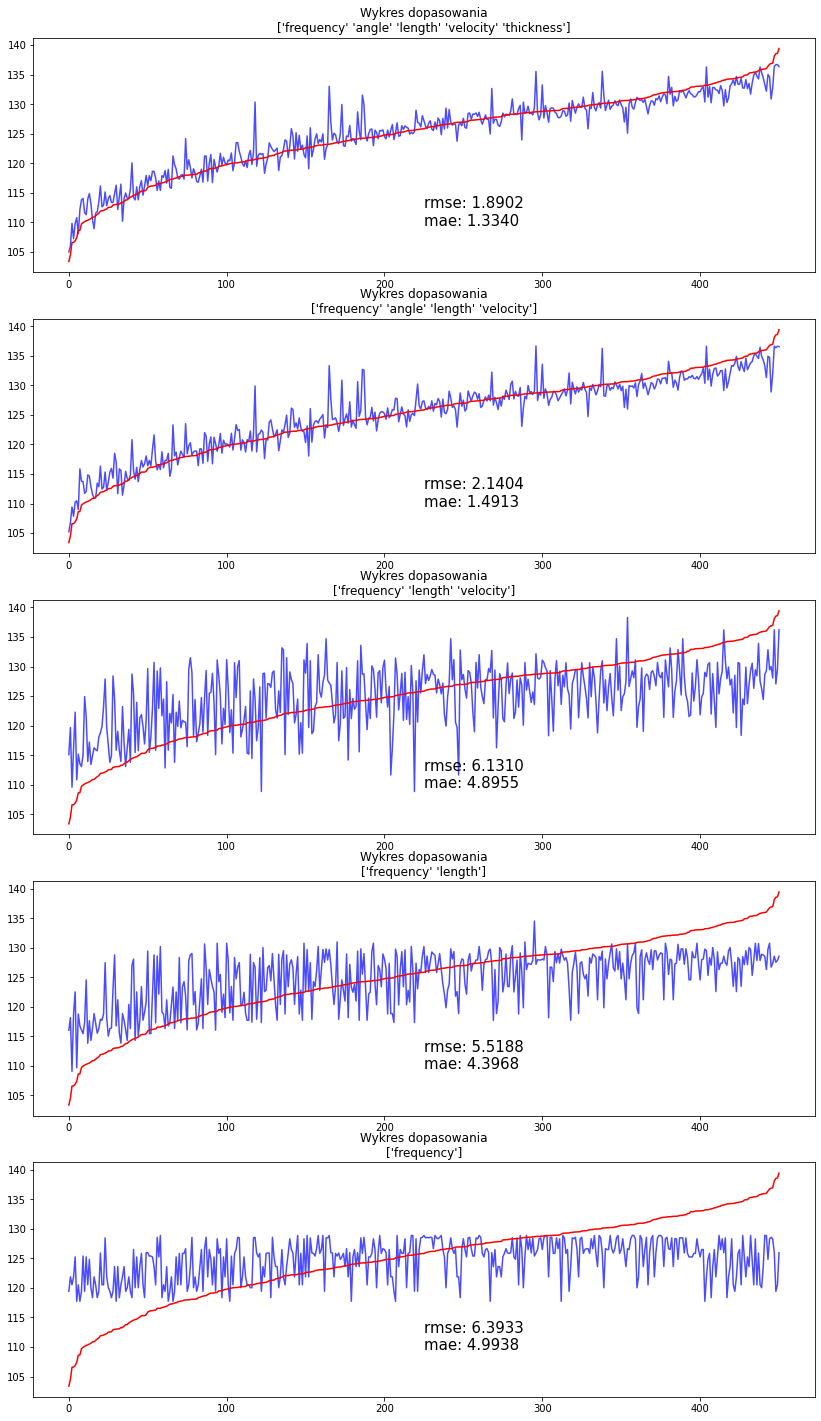

In [ ]:
rforest_models = []
for i in range(len(features_relief)):
  rforest_models.append( RandomForestRegressor(n_estimators=800) )

evaluate_models(features_relief, rforest_models, model_builder=rforest_builder(), amounts=10)

Modele MLP

In [14]:
data = [1, 2, 3, 4, 5]
index = ['thickness', 'angle', 'velocity', 'length', 'frequency']
features_relief = pd.DataFrame(data, index=index, columns=['waga'])
print(features_relief)

           waga
thickness     1
angle         2
velocity      3
length        4
frequency     5


15/15 [==============================] - 0s 2ms/step
########## AVG SCORES ########
avg rmse:   3.659 | mae:   2.773 
avg rmse:   3.852 | mae:   2.959 
avg rmse:   5.603 | mae:   4.427 
avg rmse:   5.769 | mae:   4.611 
avg rmse:   6.381 | mae:   5.120 
########## AVG SCORES ########
########## ALL SCORES ########
[[4.370718685570324, 3.3463450336329417], [3.029399173280146, 2.3069429620374864], [3.2053338405422953, 2.411147499372055], [3.394493973992675, 2.578348670705723], [2.7488169376200275, 2.2344061161557214], [4.321273735519268, 3.2993509022105822], [3.429242797218254, 2.5627191855014027], [4.257209274392777, 3.1822402220597024], [3.6062363338672987, 2.6161257550224755], [4.231498554842475, 3.196624109915249]]
[[4.895251897888088, 3.845303091112632], [3.177527728024617, 2.4745215104942573], [3.967357437397768, 2.9144804012188623], [3.708374819935221, 2.8859116953915342], [3.5134007859097007, 2.6374724744978613], [2.9137550315950653, 2.3477178779145307], [4.3773314401848795, 3.36

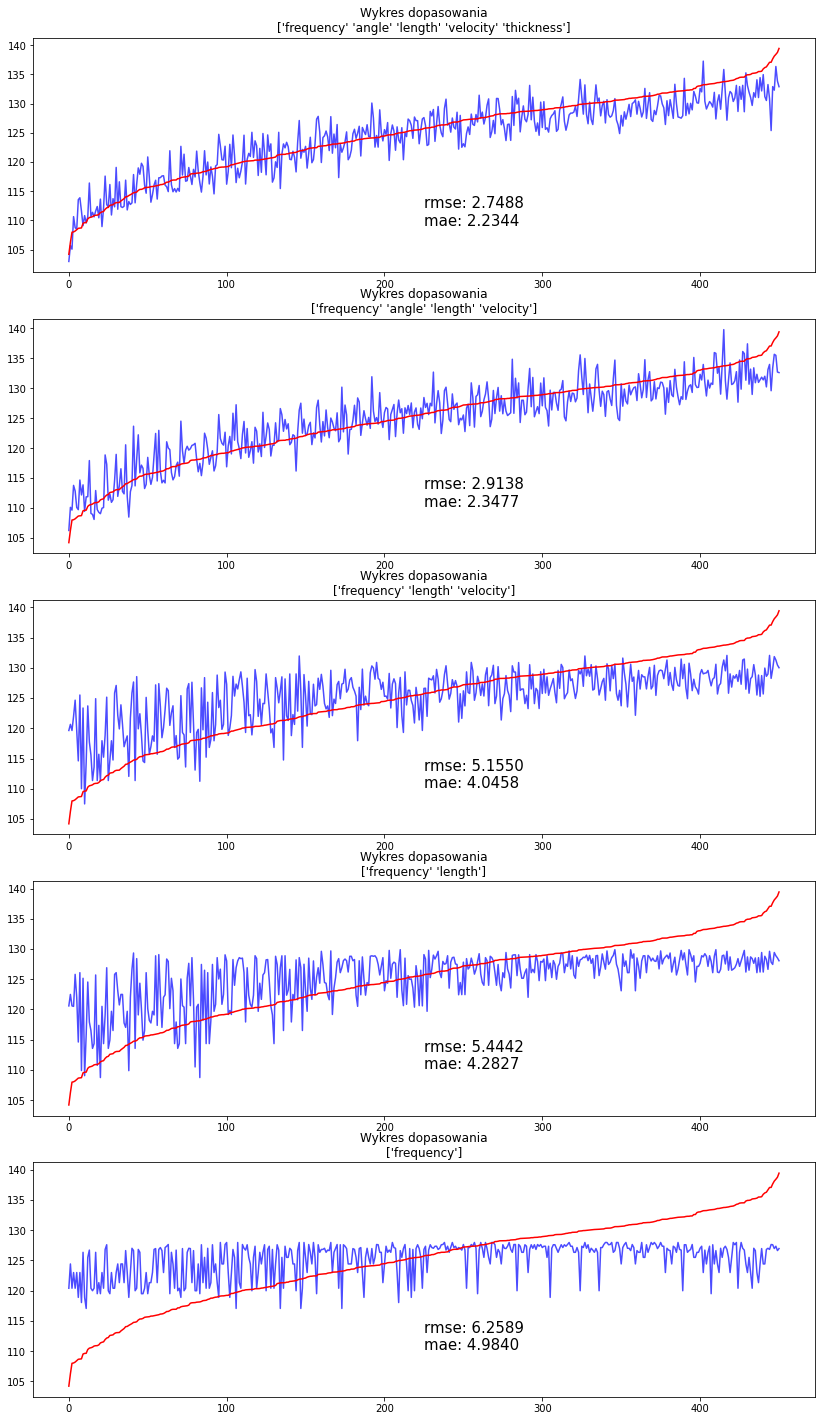

In [15]:
# stworzenie n modeli mlp
mlp_models = []
for i in range( len(features_relief) ):
  mlp_model_t = Sequential()
  mlp_model_t.add( Dense(15, input_dim=len(features_relief)-i, activation='relu') )
  mlp_model_t.add( Dense(10, activation='linear') )
  mlp_model_t.add( Dense(10, activation='linear') )
  mlp_model_t.add( Dense(1, activation='relu') )
  mlp_models.append( keras.models.clone_model(mlp_model_t) )
  mlp_models[-1].compile(loss='mse', optimizer='adam')

evaluate_models(features_relief, mlp_models, params_for_model_fitting=params_for_model_fitting, amounts=10)

Modele SVM

In [ ]:
svm_models = []
for i in range( len(features_relief) ):
  svm_models.append( SVR(C=1000, epsilon=1, gamma=5, kernel='rbf') )

evaluate_models(features_relief, svm_models, model_builder=svm_builder(), amounts=10)

########## AVG SCORES ########
avg rmse:   2.802 | mae:   1.955 
avg rmse:   2.780 | mae:   1.952 
avg rmse:   5.486 | mae:   4.326 
avg rmse:   5.422 | mae:   4.308 
avg rmse:   6.560 | mae:   5.054 
########## AVG SCORES ########


# Drzewo decyzyjne analiza istotności

Shap

In [ ]:
dtree_model = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/models/AirModels/AIR_DTREE.sav', 'rb'))

In [ ]:
Ksamples.values.shape

(100, 5)

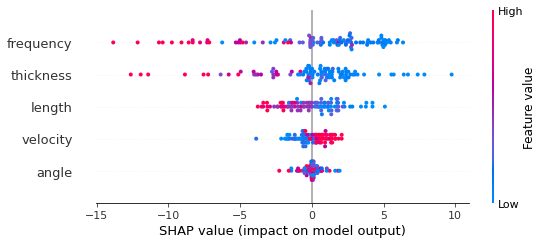

In [ ]:
dtree_shap_values = shap.TreeExplainer(dtree_model, Ksamples).shap_values(Ksamples, check_additivity=False)
shap.summary_plot(dtree_shap_values, Ksamples)

In [ ]:
feature_names = x_train.columns
shap_values_df = pd.DataFrame(dtree_shap_values, columns = feature_names )

vals = np.abs(shap_values_df.values).mean(0)
shap_importance = pd.DataFrame( list(zip(feature_names, vals)), columns = ['name', 'waga'] )
shap_importance.sort_values('waga', ascending=True, inplace=True)
shap_importance.set_index('name', inplace=True)
pickle.dump(shap_importance, open('/content/drive/MyDrive/Colab Notebooks/models/AirModels/features_shap_dtree.sav', 'wb'))
print(shap_importance)

               waga
name               
angle      0.389648
velocity   0.845154
length     1.529871
thickness  2.575213
frequency  3.654097


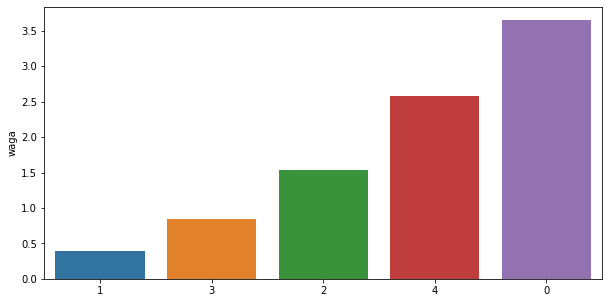

In [ ]:
plt.figure( figsize=(10, 5))
plt.tight_layout()
attr_nums = [attributes_dict[att] for att in shap_importance.index ]
sns.barplot(data=shap_importance, y='waga', x=attr_nums)

########## AVG SCORES ########
avg rmse:   2.897 | mae:   2.052 
avg rmse:   2.826 | mae:   2.017 
avg rmse:   2.861 | mae:   2.037 
avg rmse:   3.649 | mae:   2.592 
avg rmse:   6.396 | mae:   4.995 
########## AVG SCORES ########


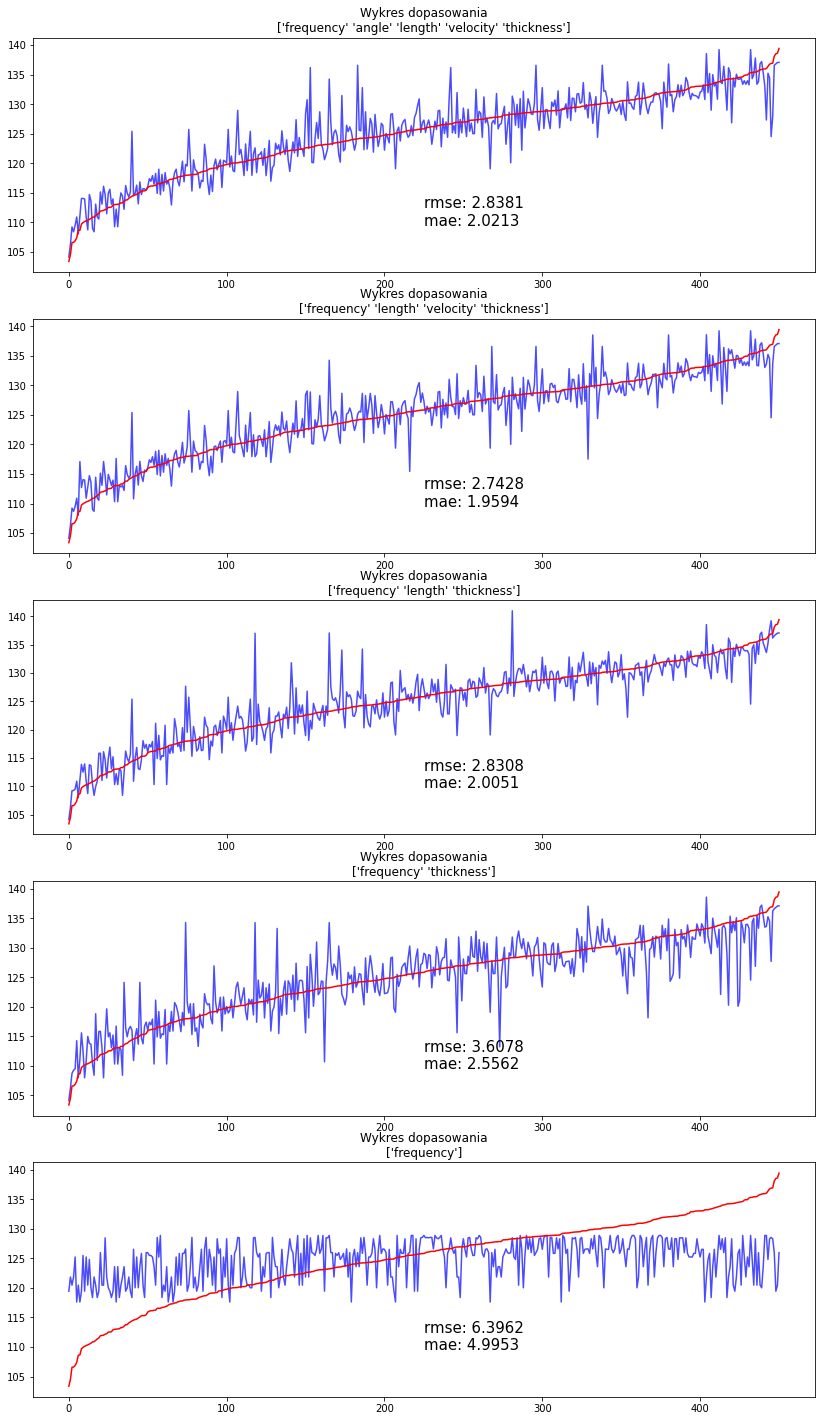

In [ ]:
dtree_models = []
for i in range( len(shap_importance) ):
  dtree_models.append( DecisionTreeRegressor() )

evaluate_models(shap_importance, dtree_models, model_builder=dtree_builder(), amounts=10)

Morris

In [ ]:
dtree_model = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/models/AirModels/AIR_DTREE.sav', 'rb'))
Y = dtree_model.predict(param_values)

X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names


In [ ]:
Si = morris.analyze(problem, param_values, Y)
Si.plot()
plt.figure( figsize=(10, 5))

features_morris = pd.DataFrame( np.abs(Si['mu']), columns=['waga'], index=Si['names'] )
features_morris.sort_values('waga', ascending=True, inplace=True)
print(features_morris)
pickle.dump(features_relief, open('/content/drive/MyDrive/Colab Notebooks/models/AirModels/features_morris_dtree.sav', 'wb'))

                waga
angle       0.042270
velocity    0.813901
length      1.509006
thickness   3.680355
frequency  10.270031


<Figure size 720x360 with 0 Axes>

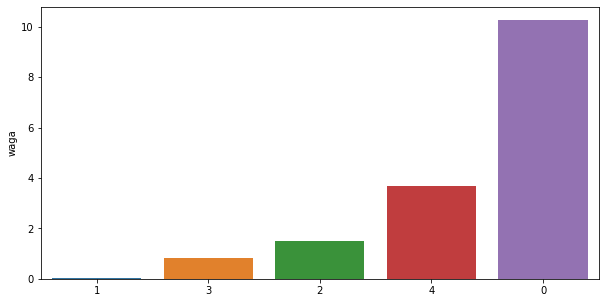

In [ ]:
plt.figure( figsize=(10, 5))
plt.tight_layout()
attr_nums = [attributes_dict[att] for att in features_morris.index ]
sns.barplot(data=features_morris, y='waga', x=attr_nums)

########## AVG SCORES ########
avg rmse:   2.883 | mae:   2.047 
avg rmse:   2.805 | mae:   2.015 
avg rmse:   2.870 | mae:   2.049 
avg rmse:   3.663 | mae:   2.604 
avg rmse:   6.396 | mae:   4.995 
########## AVG SCORES ########


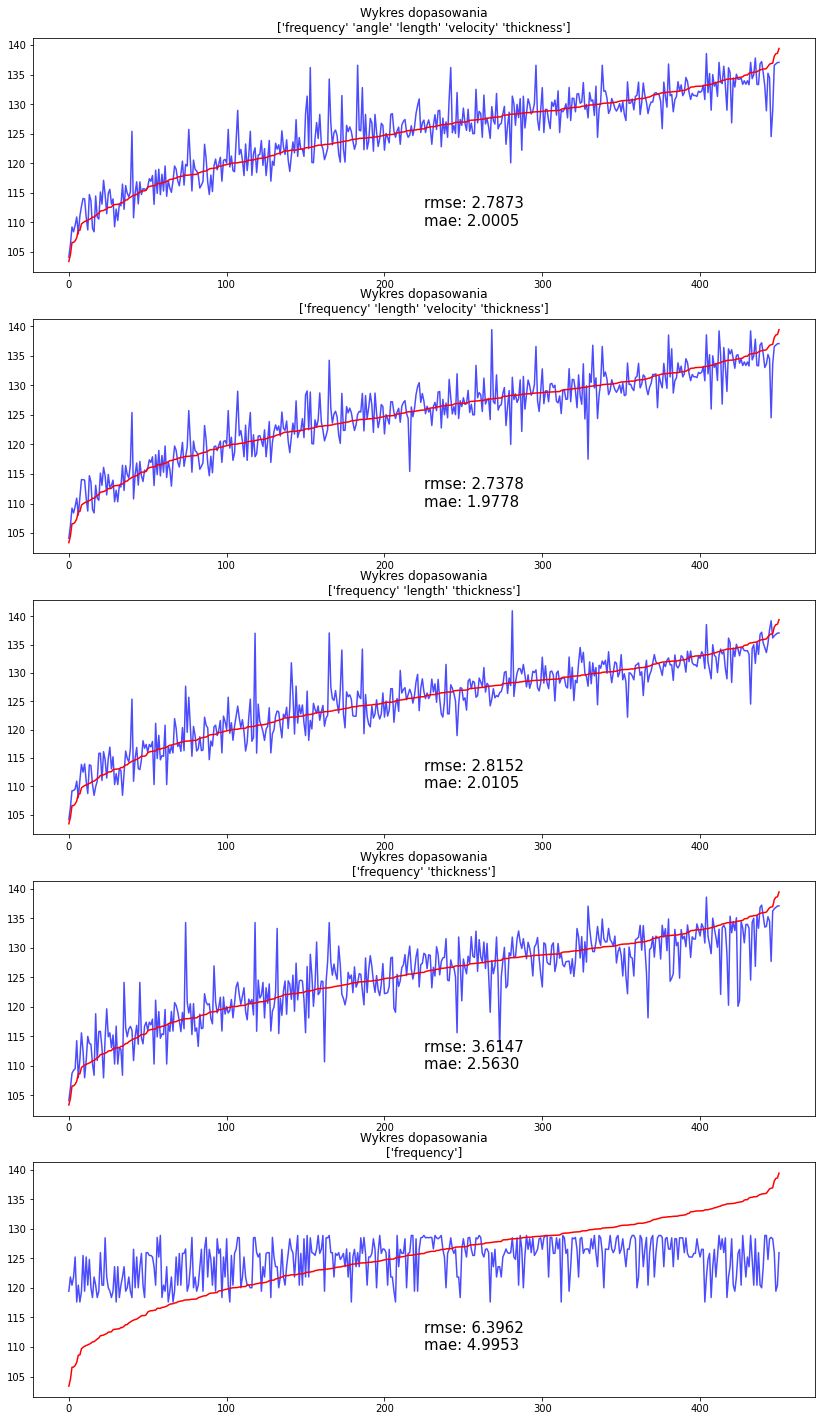

In [ ]:
evaluate_models(features_morris, dtree_models, model_builder=dtree_builder(), amounts=10)

Sobol

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f144299d3a0>,
      dtype=object)

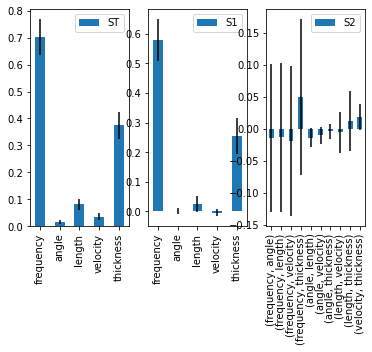

In [ ]:
Si = sobol.analyze(problem, Y)
Si.plot()

In [ ]:
features_sobol = pd.DataFrame( np.abs(Si['ST']), columns=['waga'], index=problem['names'] )
features_sobol.sort_values('waga', ascending=True, inplace=True)
print(features_sobol)
pickle.dump(features_sobol, open('/content/drive/MyDrive/Colab Notebooks/models/AirModels/features_sobol_dtree.sav', 'wb'))

               waga
angle      0.014591
velocity   0.035859
length     0.080822
thickness  0.374100
frequency  0.701890


In [ ]:
plt.figure( figsize=(10, 5))
plt.tight_layout()
attr_nums = [attributes_dict[att] for att in features_sobol.index ]
sns.barplot(data=features_sobol, y='waga', x=attr_nums)

########## AVG SCORES ########
avg rmse:   2.924 | mae:   2.066 
avg rmse:   2.812 | mae:   2.019 
avg rmse:   2.853 | mae:   2.033 
avg rmse:   3.666 | mae:   2.607 
avg rmse:   6.396 | mae:   4.995 
########## AVG SCORES ########


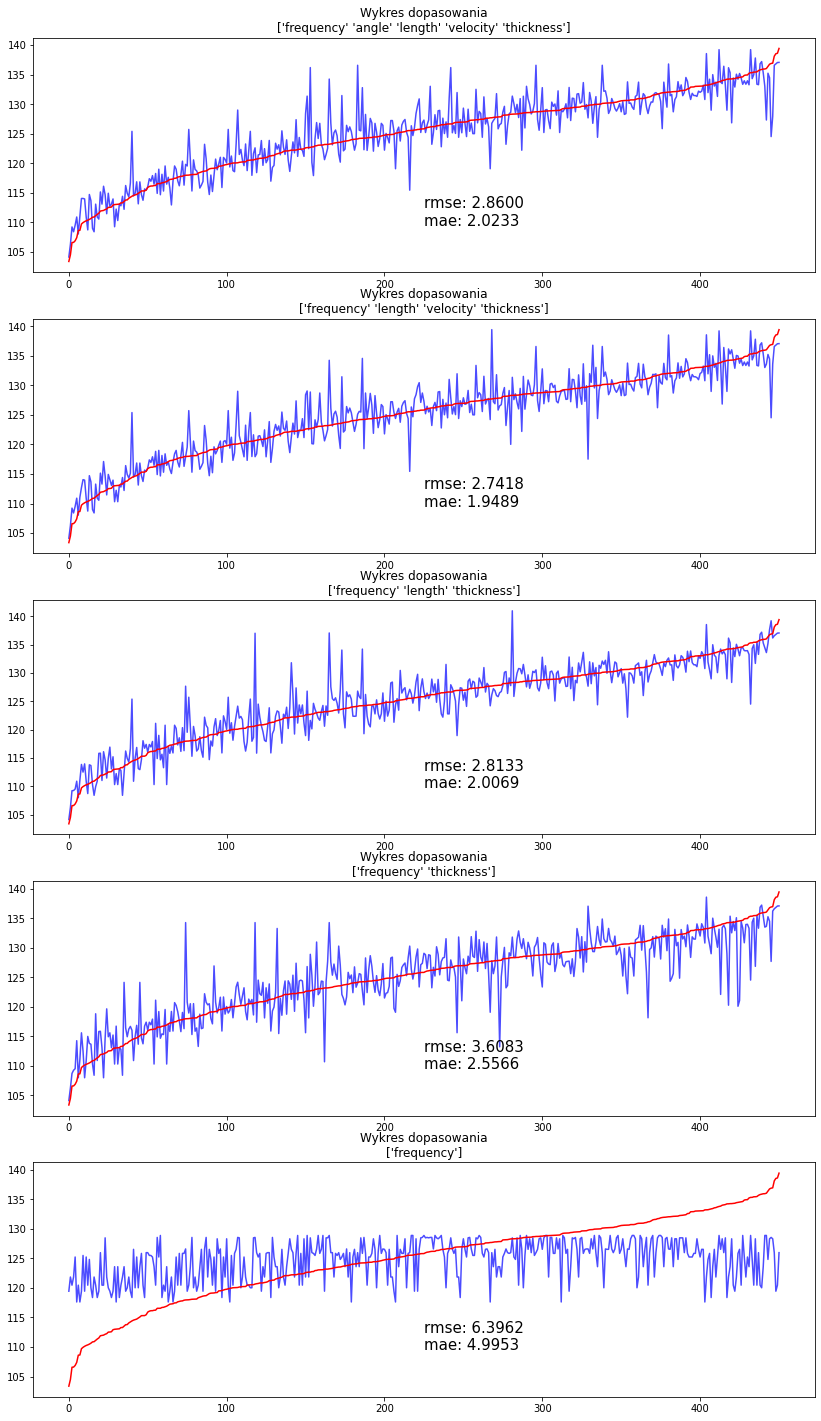

In [ ]:
evaluate_models(features_sobol, dtree_models, model_builder=dtree_builder(), amounts=10)

# Model Randomowych lasów analiza istotności

Shap

 99%|===================| 99/100 [00:26<00:00]       

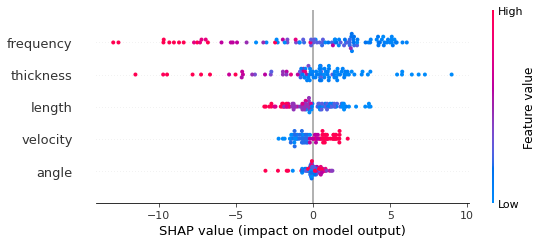

In [ ]:
rforest_model = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/models/AirModels/AIR_RFOREST.sav', 'rb'))
rforest_shap_values = shap.TreeExplainer(rforest_model, Ksamples).shap_values(Ksamples)
shap.summary_plot(rforest_shap_values, Ksamples)

In [ ]:
feature_names = x_train.columns
shap_values_df = pd.DataFrame(rforest_shap_values, columns = feature_names )

vals = np.abs(shap_values_df.values).mean(0)
shap_importance = pd.DataFrame( list(zip(feature_names, vals)), columns = ['name', 'waga'] )
shap_importance.sort_values('waga', ascending=True, inplace=True)
shap_importance.set_index('name', inplace=True)

print(shap_importance)
pickle.dump(shap_importance, open('/content/drive/MyDrive/Colab Notebooks/models/AirModels/features_shap_rforest.sav', 'wb'))

               waga
name               
angle      0.394633
velocity   0.885673
length     1.271453
thickness  2.246712
frequency  3.590646


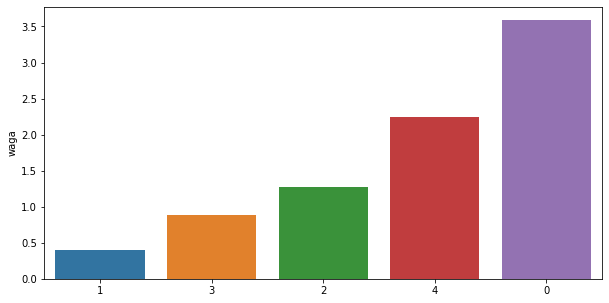

In [ ]:
plt.figure( figsize=(10, 5))
plt.tight_layout()
attr_nums = [attributes_dict[att] for att in shap_importance.index ]
sns.barplot(data=shap_importance, y='waga', x=attr_nums)

########## AVG SCORES ########
avg rmse:   1.902 | mae:   1.343 
avg rmse:   1.877 | mae:   1.347 
avg rmse:   2.051 | mae:   1.483 
avg rmse:   2.968 | mae:   2.169 
avg rmse:   6.397 | mae:   4.996 
########## AVG SCORES ########


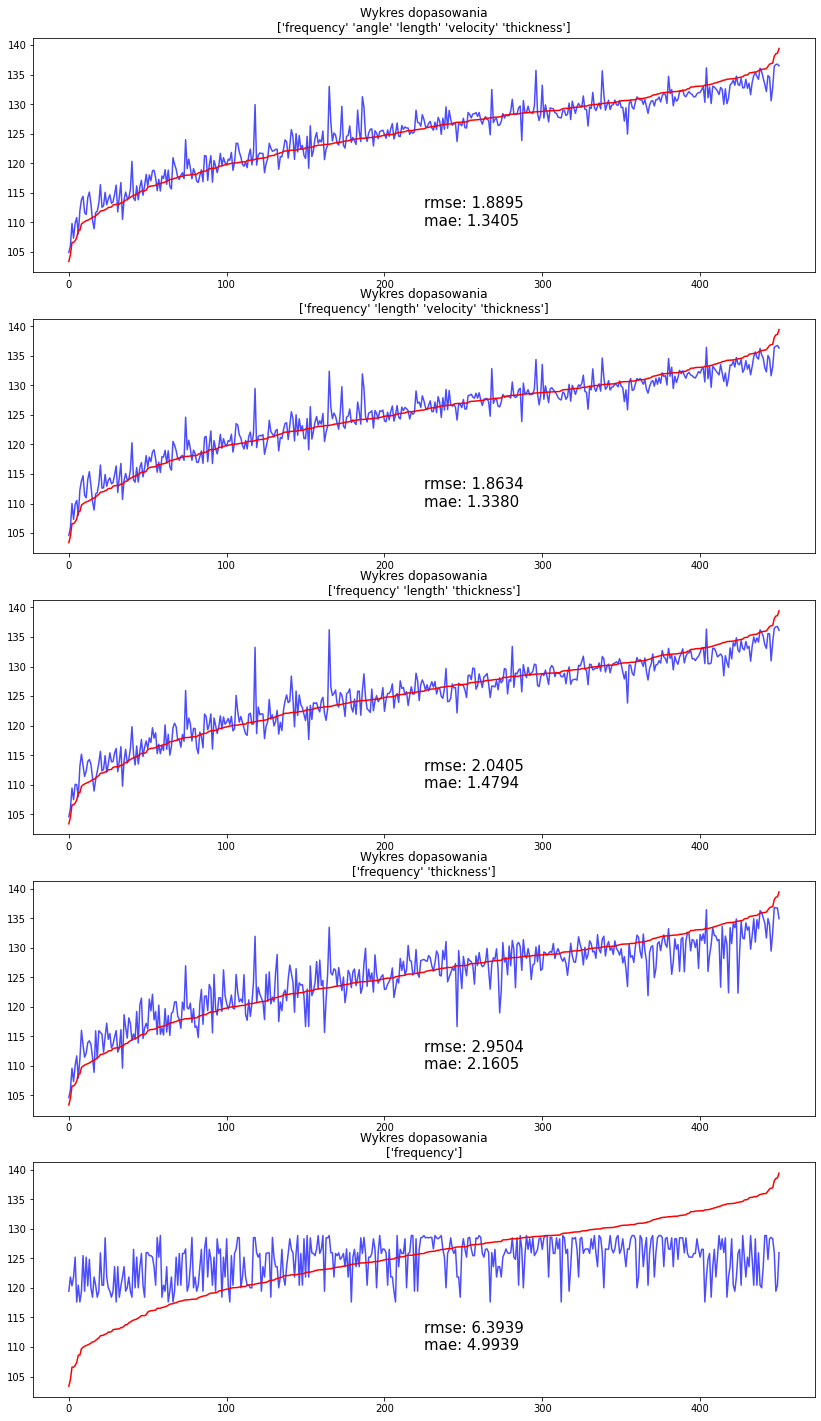

In [ ]:
rforest_models = []
for i in range( len(shap_importance) ):
  rforest_models.append( RandomForestRegressor(n_estimators=1) )

evaluate_models(shap_importance, rforest_models, model_builder=rforest_builder(), amounts=10)

Morris

In [ ]:
Y = rforest_model.predict(param_values)

X does not have valid feature names, but RandomForestRegressor was fitted with feature names


<Figure size 720x360 with 0 Axes>

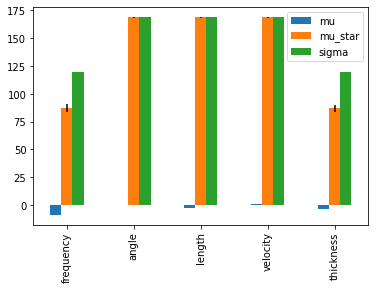

<Figure size 720x360 with 0 Axes>

In [ ]:
Si = morris.analyze(problem, param_values, Y)
Si.plot()
plt.figure( figsize=(10, 5))

In [ ]:
features_morris = pd.DataFrame( np.abs(Si['mu']), columns=['waga'], index=Si['names'] )
features_morris.sort_values('waga', ascending=True, inplace=True)
print(features_morris)
pickle.dump(features_morris, open('/content/drive/MyDrive/Colab Notebooks/models/AirModels/features_morris_rforest.sav', 'wb'))

               waga
angle      0.072370
velocity   1.015258
length     2.376598
thickness  3.677408
frequency  8.791893


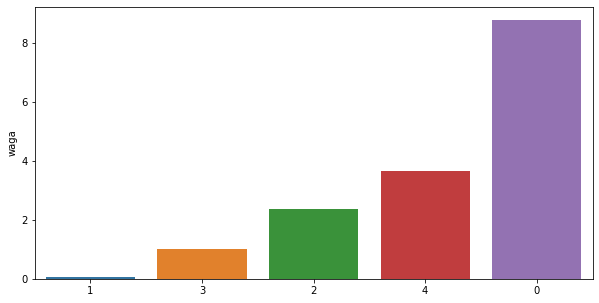

In [ ]:
plt.figure( figsize=(10, 5))
plt.tight_layout()
attr_nums = [attributes_dict[att] for att in features_morris.index ]
sns.barplot(data=features_morris, y='waga', x=attr_nums)

########## AVG SCORES ########
avg rmse:   1.907 | mae:   1.345 
avg rmse:   1.886 | mae:   1.349 
avg rmse:   2.046 | mae:   1.479 
avg rmse:   2.971 | mae:   2.171 
avg rmse:   6.397 | mae:   4.996 
########## AVG SCORES ########


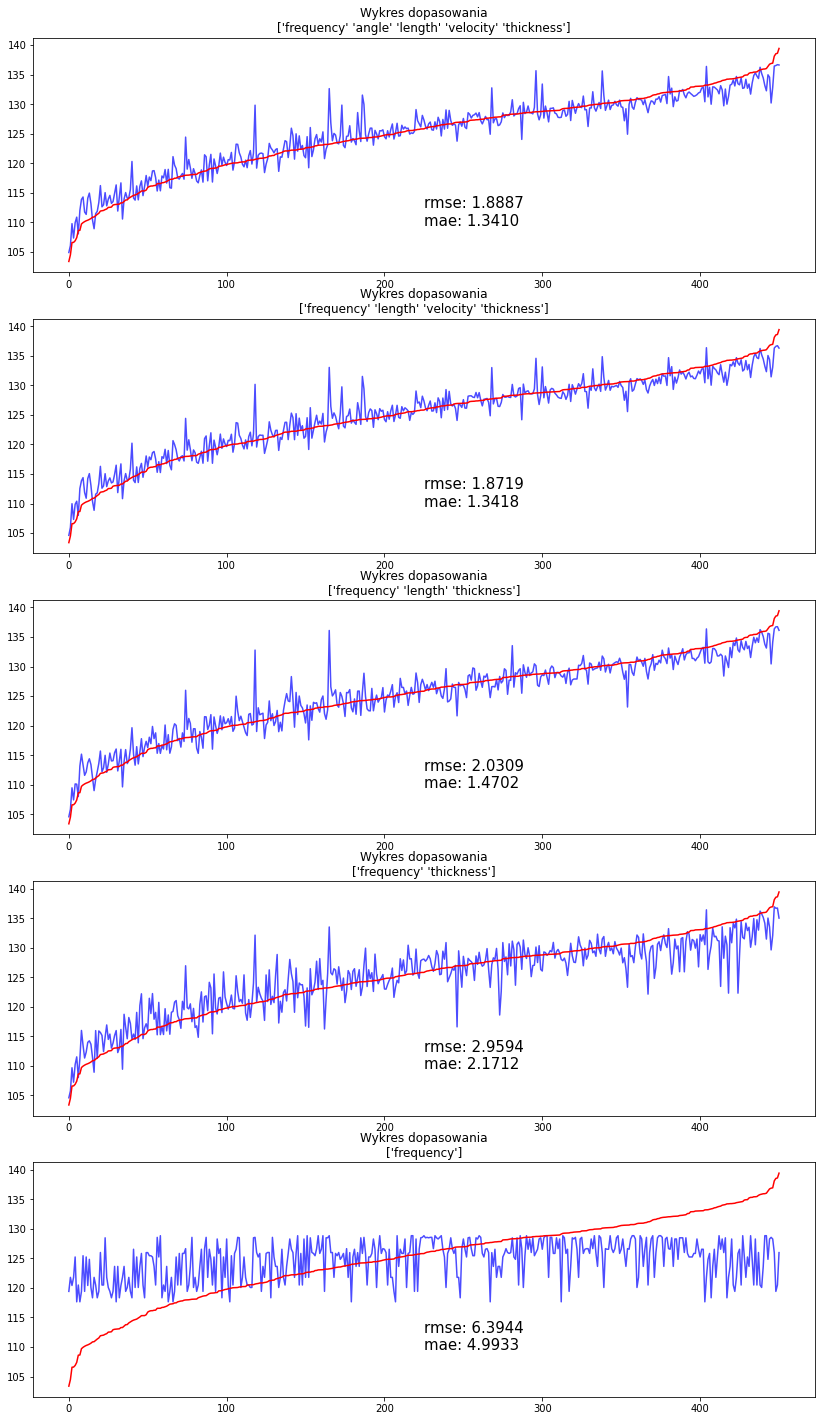

In [ ]:
evaluate_models(features_morris, rforest_models, model_builder=rforest_builder(), amounts=10)

Sobol

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f144b936280>,
      dtype=object)

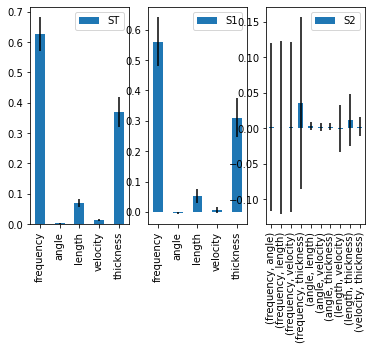

In [ ]:
Si = sobol.analyze(problem, Y)
Si.plot()

In [ ]:
features_sobol = pd.DataFrame( np.abs(Si['ST']), columns=['waga'], index=problem['names'] )
features_sobol.sort_values('waga', ascending=True, inplace=True)
print(features_sobol)
pickle.dump(features_sobol, open('/content/drive/MyDrive/Colab Notebooks/models/AirModels/features_sobol_rforest.sav', 'wb'))

               waga
angle      0.002796
velocity   0.012972
length     0.069142
thickness  0.369407
frequency  0.626790


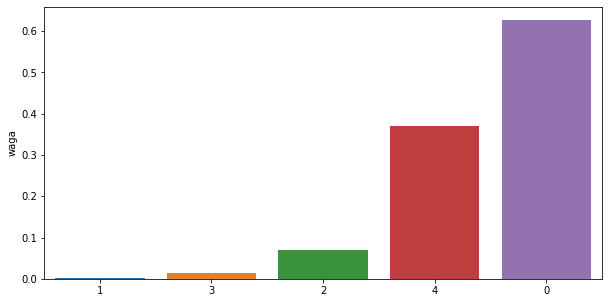

In [ ]:
plt.figure( figsize=(10, 5))
plt.tight_layout()
attr_nums = [attributes_dict[att] for att in features_sobol.index ]
sns.barplot(data=features_sobol, y='waga', x=attr_nums)

########## AVG SCORES ########
avg rmse:   1.904 | mae:   1.345 
avg rmse:   1.888 | mae:   1.351 
avg rmse:   2.052 | mae:   1.483 
avg rmse:   2.965 | mae:   2.166 
avg rmse:   6.396 | mae:   4.995 
########## AVG SCORES ########


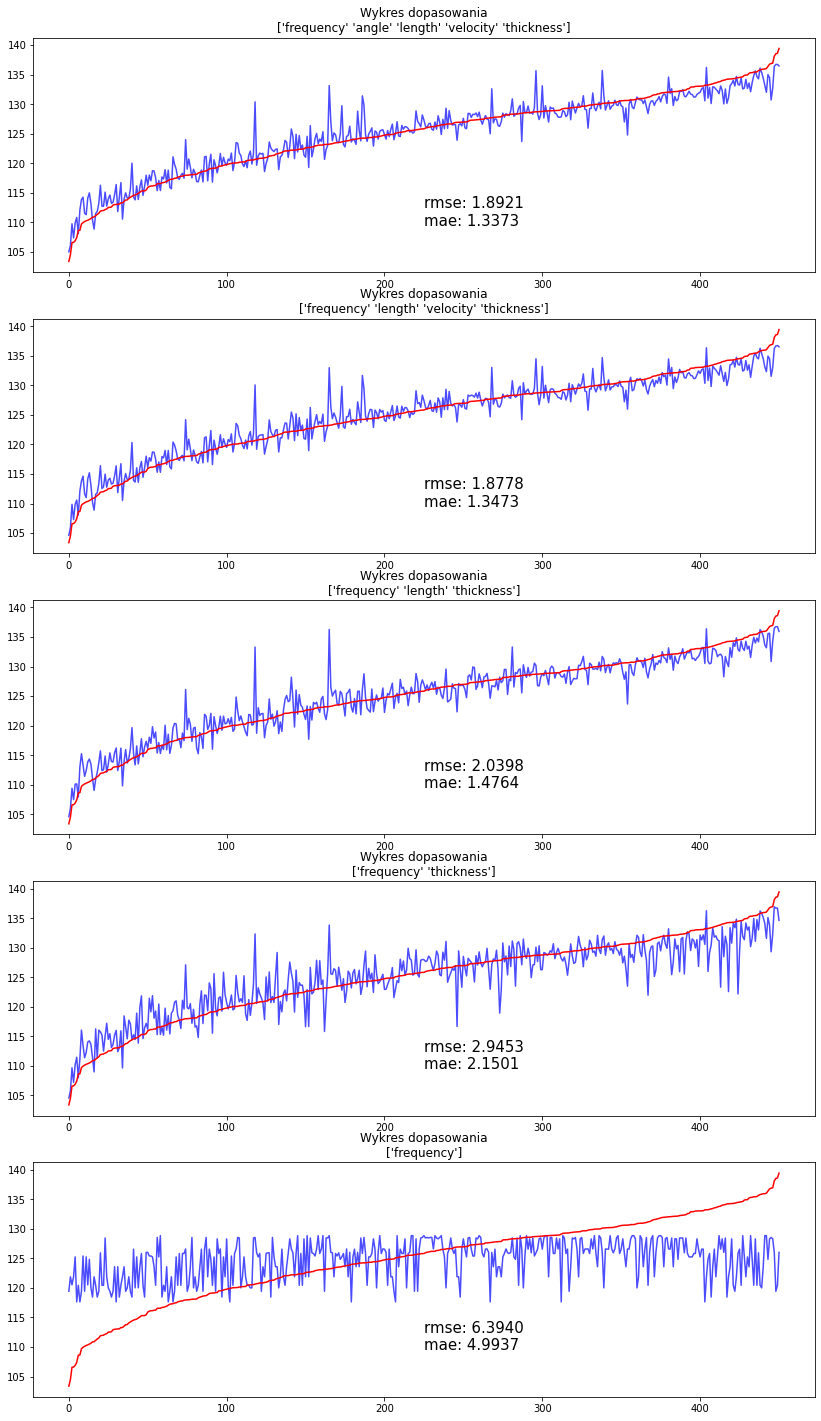

In [ ]:
evaluate_models(features_sobol, rforest_models, model_builder=rforest_builder(), amounts=10)

# Model MLP analiza istotności

Shap

In [ ]:
mlp_model = keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/models/AirModels/AIR_MLP')

  0%|          | 0/100 [00:00<?, ?it/s]

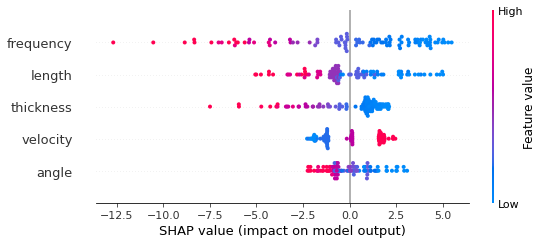

In [ ]:
mlp_shap_values = shap.KernelExplainer(mlp_model, Ksamples).shap_values(Ksamples)
shap.summary_plot(mlp_shap_values[0], Ksamples)

In [ ]:
feature_names = x_train.columns
shap_values_df = pd.DataFrame(mlp_shap_values[0], columns = feature_names )

vals = np.abs(shap_values_df.values).mean(0)
shap_importance = pd.DataFrame( list(zip(feature_names, vals)), columns = ['name', 'waga'] )
shap_importance.sort_values('waga', ascending=True, inplace=True)
shap_importance.set_index('name', inplace=True)

print(shap_importance)
pickle.dump(shap_importance, open('/content/drive/MyDrive/Colab Notebooks/models/AirModels/features_shap_mlp.sav', 'wb'))

               waga
name               
angle      1.070823
velocity   1.425952
thickness  1.649040
length     1.814208
frequency  3.280398


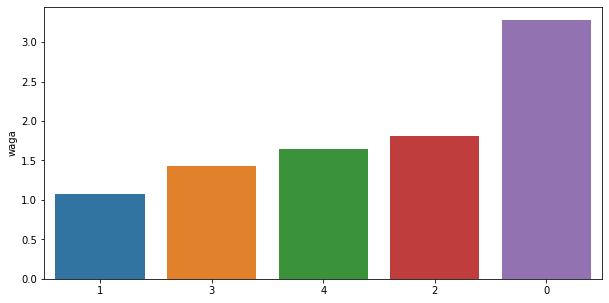

In [ ]:
plt.figure( figsize=(10, 5))
plt.tight_layout()
attr_nums = [attributes_dict[att] for att in shap_importance.index ]
sns.barplot(data=shap_importance, y='waga', x=attr_nums)

15/15 [==============================] - 0s 2ms/step
########## AVG SCORES ########
avg rmse:   3.756 | mae:   2.805 
avg rmse:   3.584 | mae:   2.728 
avg rmse:   4.057 | mae:   3.132 
avg rmse:   5.711 | mae:   4.558 
avg rmse:   6.401 | mae:   5.115 
########## AVG SCORES ########
########## ALL SCORES ########
[[4.383401858748679, 3.28476854088354], [3.3546767082939613, 2.5218362541790804], [3.479087815302979, 2.561486074781735], [4.602159953030867, 3.4548988437694876], [2.9508983015597607, 2.3055216600371566], [4.418342270128926, 3.2535747844416925], [3.075503826940628, 2.388013980975436], [3.548480139880063, 2.4615248770364895], [3.2949487129906063, 2.480938097630266], [4.448166885960387, 3.3421342458111747]]
[[3.422240692403064, 2.5748764388598255], [4.307358156444333, 3.17726161061898], [3.4457386510125962, 2.589076754077311], [3.834743282159751, 2.927399534508818], [3.184043723265756, 2.394669593151287], [3.6121316795757847, 2.7552522438201565], [3.5535116334351065, 2.71678779

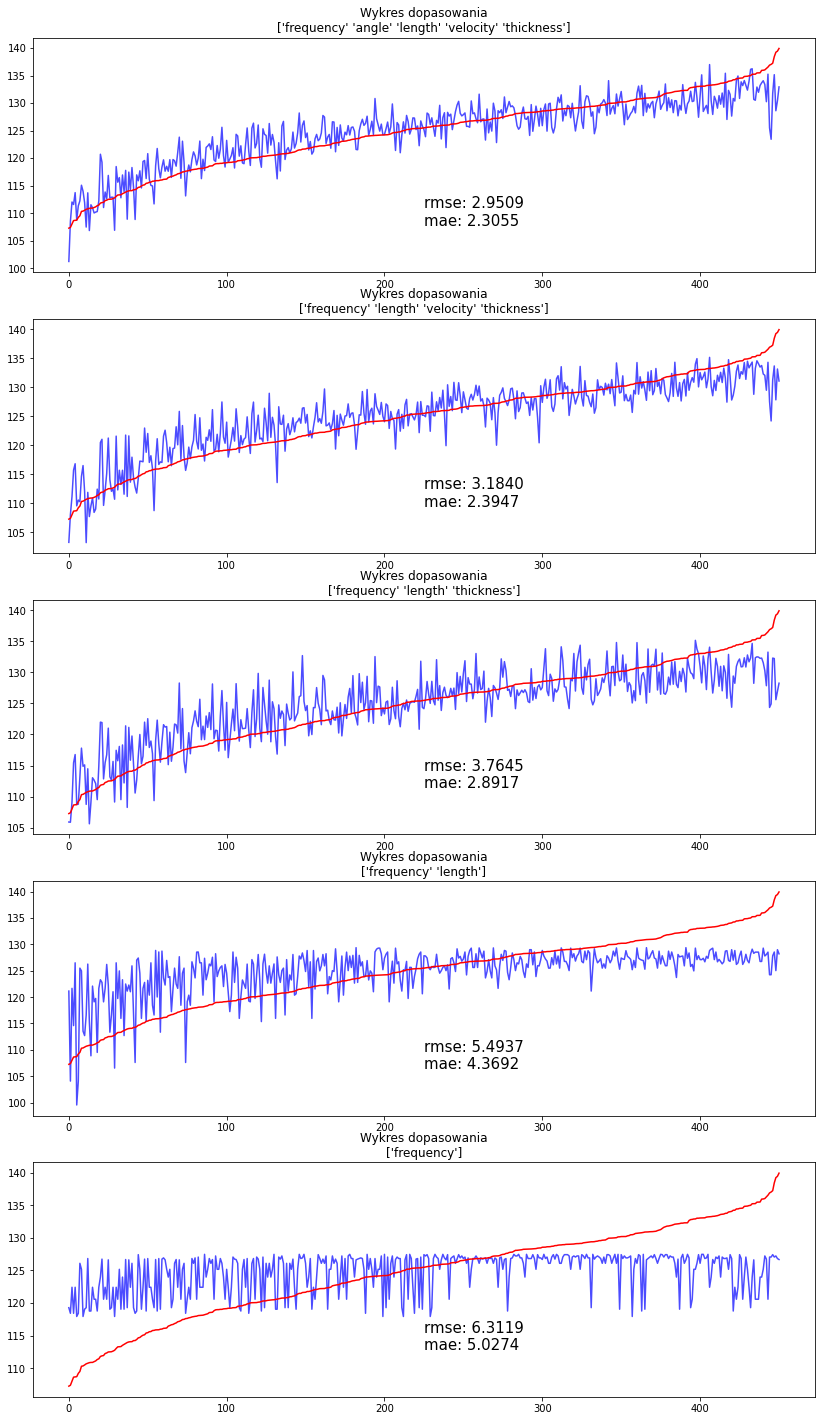

In [ ]:
# stworzenie n modeli mlp
mlp_models = []
for i in range( len(shap_importance) ):
  mlp_model_t = Sequential()
  mlp_model_t.add( Dense(15, input_dim=len(shap_importance)-i, activation='relu') )
  mlp_model_t.add( Dense(10, activation='linear') )
  mlp_model_t.add( Dense(10, activation='linear') )
  mlp_model_t.add( Dense(1, activation='relu') )
  mlp_models.append( keras.models.clone_model(mlp_model_t) )
  mlp_models[-1].compile(loss='mse', optimizer='adam')

evaluate_models(shap_importance, mlp_models, params_for_model_fitting, amounts=10)

Morris

In [ ]:
#print( param_values.shape )
#print( mlp_model.summary() )

Y = mlp_model.predict(param_values)

384/384 [==============================] - 1s 1ms/step


<Figure size 720x360 with 0 Axes>

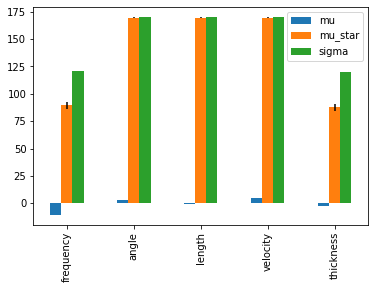

<Figure size 720x360 with 0 Axes>

In [ ]:
Si = morris.analyze(problem, param_values, Y)
Si.plot()
plt.figure( figsize=(10, 5))

In [ ]:
features_morris = pd.DataFrame( np.abs(Si['mu']), columns=['waga'], index=Si['names'] )
features_morris.sort_values('waga', ascending=True, inplace=True)
print(features_morris)
pickle.dump(features_morris, open('/content/drive/MyDrive/Colab Notebooks/models/AirModels/features_morris_mlp.sav', 'wb'))

                waga
length      1.112909
angle       2.723863
thickness   2.755570
velocity    4.662599
frequency  10.504535


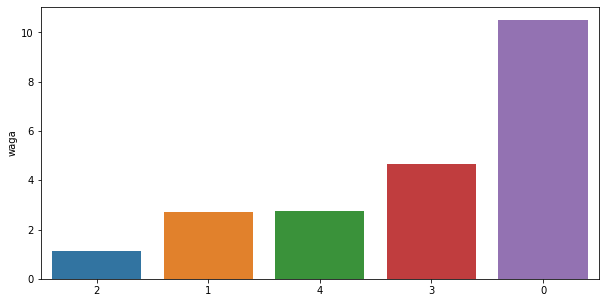

In [ ]:
plt.figure( figsize=(10, 5))
plt.tight_layout()
attr_nums = [attributes_dict[att] for att in features_morris.index ]
sns.barplot(data=features_morris, y='waga', x=attr_nums)

15/15 [==============================] - 0s 2ms/step
########## AVG SCORES ########
avg rmse:   3.597 | mae:   2.717 
avg rmse:   4.445 | mae:   3.442 
avg rmse:   4.556 | mae:   3.556 
avg rmse:   6.258 | mae:   5.009 
avg rmse:   6.439 | mae:   5.135 
########## AVG SCORES ########
########## ALL SCORES ########
[[4.469506132316184, 3.4053776984035045], [3.5217083090223067, 2.672708304056307], [3.021881231055799, 2.3417292810681123], [4.425808388597855, 3.3138510723240886], [3.5221987654095157, 2.63773449328099], [3.384257326918583, 2.5372016820801866], [3.3683031095547316, 2.5647325023981002], [3.413601327874676, 2.590045792471807], [4.316999766117441, 3.187880612121717], [2.5295865246505076, 1.9160098622527197]]
[[4.876502710130083, 3.7915485462264846], [4.465386475403355, 3.393942359670567], [5.678667199468001, 4.513021607663309], [3.7858915665761512, 2.8963897575158506], [4.490831538665584, 3.406147305033952], [3.8949412781056996, 3.017335841819611], [4.896415694368278, 3.7519612

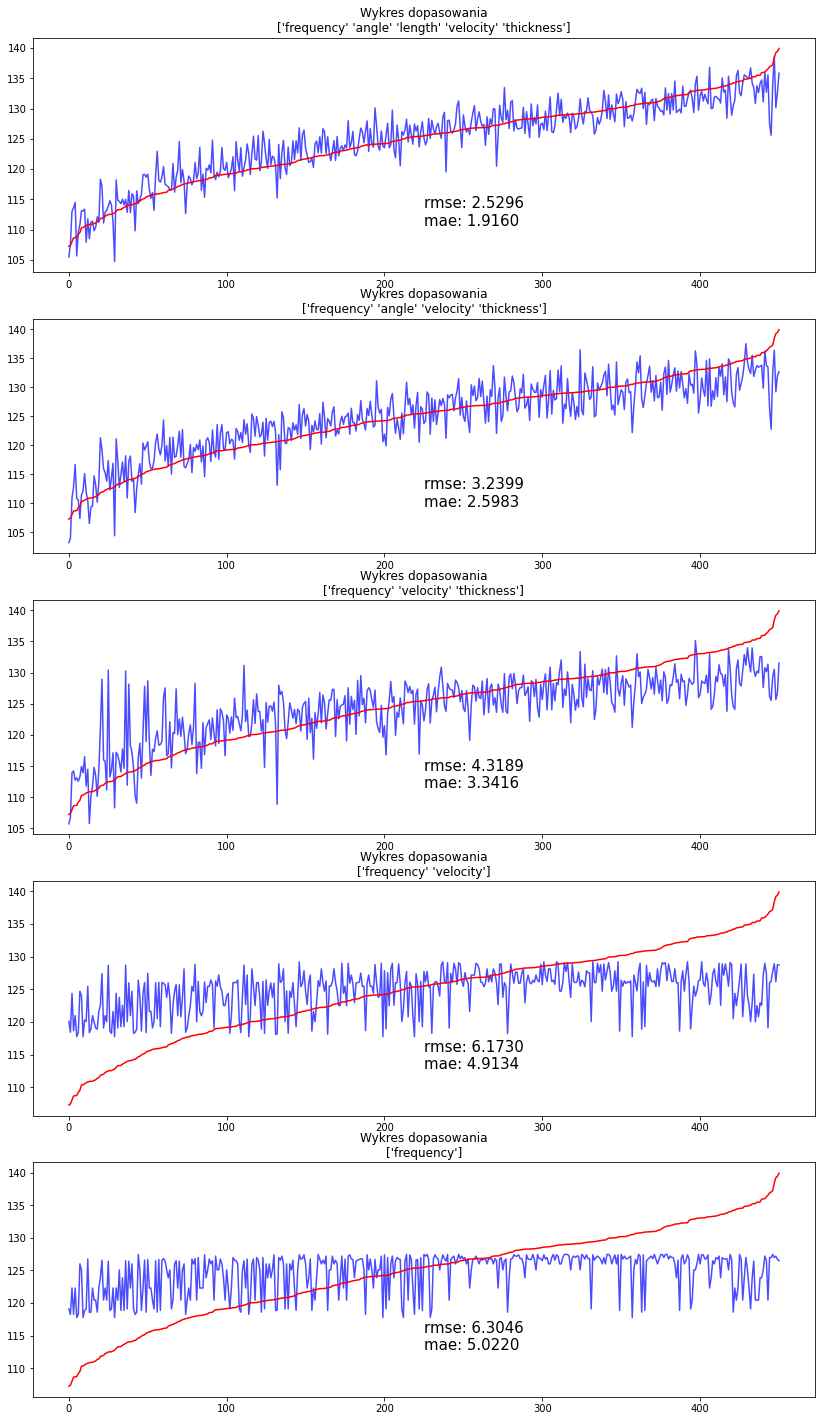

In [ ]:
# wykresy dla Morris

# stworzenie n modeli mlp
mlp_models = []
for i in range( len(shap_importance) ):
  mlp_model_t = Sequential()
  mlp_model_t.add( Dense(15, input_dim=len(shap_importance)-i, activation='relu') )
  mlp_model_t.add( Dense(10, activation='linear') )
  mlp_model_t.add( Dense(10, activation='linear') )
  mlp_model_t.add( Dense(1, activation='relu') )
  mlp_models.append( keras.models.clone_model(mlp_model_t) )
  mlp_models[-1].compile(loss='mse', optimizer='adam')

evaluate_models(features_morris, mlp_models, params_for_model_fitting, amounts=10)

Sobol

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f656bc76d60>,
      dtype=object)

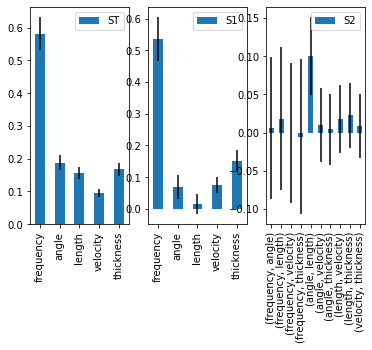

In [ ]:
Y = Y.reshape(-1)
Si = sobol.analyze(problem, Y)
Si.plot()

In [ ]:
features_sobol = pd.DataFrame( np.abs(Si['ST']), columns=['waga'], index=problem['names'] )
features_sobol.sort_values('waga', ascending=True, inplace=True)
print(features_sobol)
pickle.dump(features_sobol, open('/content/drive/MyDrive/Colab Notebooks/models/AirModels/features_sobol_mlp.sav', 'wb'))

               waga
velocity   0.095716
length     0.156143
thickness  0.167040
angle      0.187258
frequency  0.581548


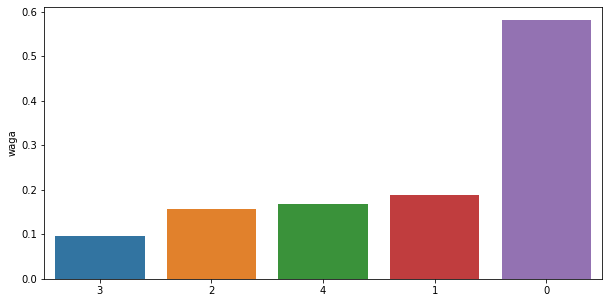

In [ ]:
plt.figure( figsize=(10, 5))
plt.tight_layout()
attr_nums = [attributes_dict[att] for att in features_sobol.index ]
sns.barplot(data=features_sobol, y='waga', x=attr_nums)

15/15 [==============================] - 0s 2ms/step
########## AVG SCORES ########
avg rmse:   3.711 | mae:   2.792 
avg rmse:   3.915 | mae:   2.987 
avg rmse:   4.783 | mae:   3.709 
avg rmse:   5.883 | mae:   4.713 
avg rmse:   6.416 | mae:   5.143 
########## AVG SCORES ########
########## ALL SCORES ########
[[4.364007297393231, 3.2520272061163995], [4.404545870752712, 3.3115993457464312], [3.67490774191278, 2.705558985674196], [2.8155204907897895, 2.170586270013035], [3.4946528791953395, 2.6704432873778754], [3.3934273587549413, 2.5520223695877653], [4.428470367090426, 3.295396764108188], [4.294685454590291, 3.203348817541964], [2.8577079327750354, 2.1882174900503224], [3.3853162157660432, 2.569817692724934]]
[[4.650854260392922, 3.5331016068892045], [3.7449797022151237, 2.9370588557545734], [3.7179067263817, 2.8568442704904897], [3.4728188196120593, 2.6620462124099227], [3.9384923068013302, 2.890623183290604], [3.287455927962011, 2.543866180352256], [4.6504577166327605, 3.59632

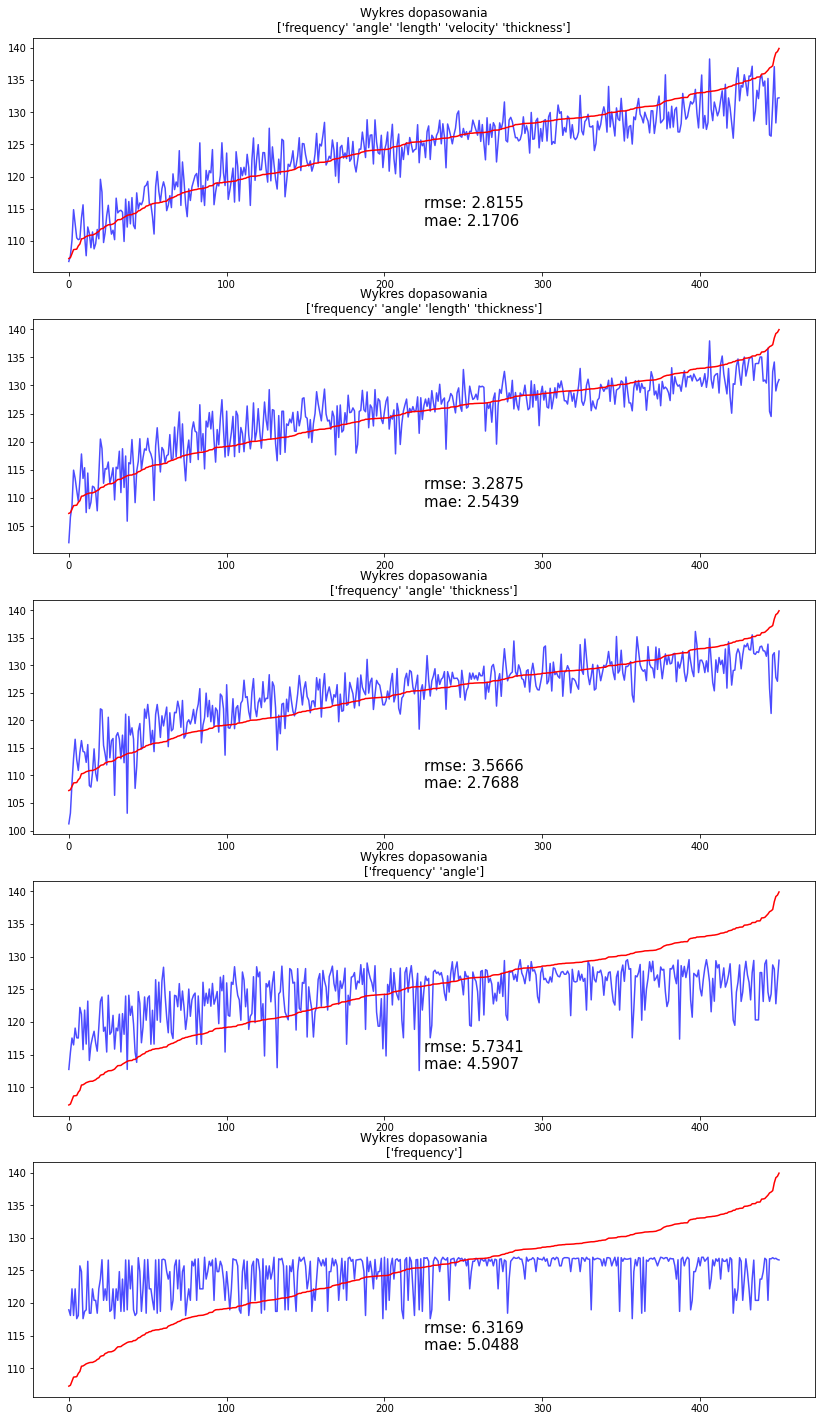

In [ ]:
# wykresy dla Sobol

# stworzenie n modeli mlp
mlp_models = []
for i in range( len(shap_importance) ):
  mlp_model_t = Sequential()
  mlp_model_t.add( Dense(15, input_dim=len(shap_importance)-i, activation='relu') )
  mlp_model_t.add( Dense(10, activation='linear') )
  mlp_model_t.add( Dense(10, activation='linear') )
  mlp_model_t.add( Dense(1, activation='relu') )
  mlp_models.append( keras.models.clone_model(mlp_model_t) )
  mlp_models[-1].compile(loss='mse', optimizer='adam')

evaluate_models(features_sobol, mlp_models, params_for_model_fitting, amounts=10)

# Model SVM analiza istotności

In [ ]:
svm_model = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/models/AirModels/AIR_SVM.sav', 'rb'))

In [ ]:
svm_shap_values = shap.KernelExplainer(svm_model.predict, Ksamples).shap_values(Ksamples)
shap.summary_plot(svm_shap_values, Ksamples)

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
feature_names = x_train.columns
shap_values_df = pd.DataFrame(svm_shap_values, columns = feature_names )

vals = np.abs(shap_values_df.values).mean(0)
shap_importance = pd.DataFrame( list(zip(feature_names, vals)), columns = ['name', 'waga'] )
shap_importance.sort_values('waga', ascending=True, inplace=True)
shap_importance.set_index('name', inplace=True)

print(shap_importance)
pickle.dump(shap_importance, open('/content/drive/MyDrive/Colab Notebooks/models/AirModels/features_shap_svm.sav', 'wb'))

               waga
name               
velocity   1.259210
angle      1.375788
thickness  1.711079
length     2.269588
frequency  3.503440


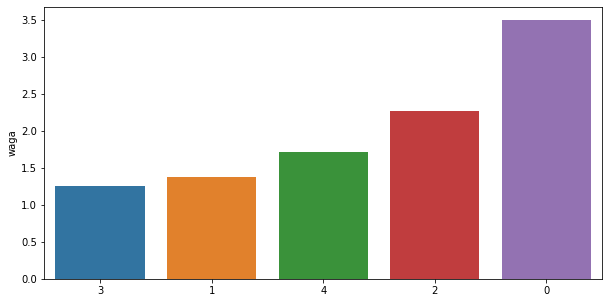

In [ ]:
plt.figure( figsize=(10, 5))
plt.tight_layout()
attr_nums = [attributes_dict[att] for att in shap_importance.index ]
sns.barplot(data=shap_importance, y='waga', x=attr_nums)

In [ ]:
# wykresy dla shap
svm_models = []
for i in range( len(shap_importance) ):
  svm_models.append( SVR(C=1000, epsilon=1, gamma=5, kernel='rbf') )


evaluate_models(shap_importance, svm_models, model_builder=svm_builder(), amounts=1)

########## AVG SCORES ########
avg rmse:   2.926 | mae:   2.027 
avg rmse:   2.725 | mae:   1.900 
avg rmse:   3.051 | mae:   2.161 
avg rmse:   5.207 | mae:   4.016 
avg rmse:   6.178 | mae:   4.746 
########## AVG SCORES ########


Morris

In [ ]:
Y = svm_model.predict(param_values)

<Figure size 720x360 with 0 Axes>

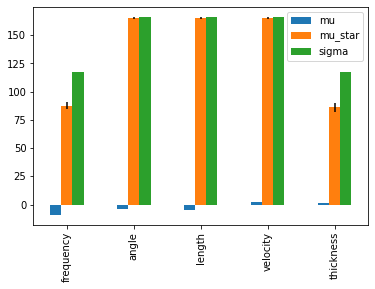

<Figure size 720x360 with 0 Axes>

In [ ]:
Si = morris.analyze(problem, param_values, Y)
Si.plot()
plt.figure( figsize=(10, 5))

In [ ]:
features_morris = pd.DataFrame( np.abs(Si['mu']), columns=['waga'], index=Si['names'] )
features_morris.sort_values('waga', ascending=True, inplace=True)
print(features_morris)
pickle.dump(features_morris, open('/content/drive/MyDrive/Colab Notebooks/models/AirModels/features_morris_svm.sav', 'wb'))

               waga
thickness  1.202125
velocity   1.914004
angle      3.707462
length     4.542313
frequency  8.917711


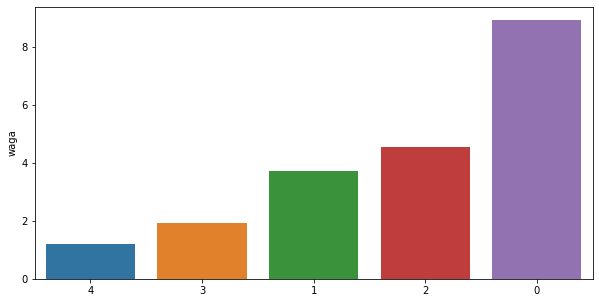

In [ ]:
plt.figure( figsize=(10, 5))
plt.tight_layout()
attr_nums = [attributes_dict[att] for att in features_morris.index ]
sns.barplot(data=features_morris, y='waga', x=attr_nums)

In [ ]:
# wykresy dla morris
evaluate_models(features_morris, svm_models, model_builder=svm_builder(), amounts=1)

########## AVG SCORES ########
avg rmse:   2.926 | mae:   2.027 
avg rmse:   2.868 | mae:   2.040 
avg rmse:   3.263 | mae:   2.414 
avg rmse:   5.207 | mae:   4.016 
avg rmse:   6.178 | mae:   4.746 
########## AVG SCORES ########


Sobol

In [ ]:
Si = sobol.analyze(problem, Y)
Si.plot()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f790e819c40>,
      dtype=object)

In [ ]:
features_sobol = pd.DataFrame( np.abs(Si['ST']), columns=['waga'], index=problem['names'] )
features_sobol.sort_values('waga', ascending=True, inplace=True)
print(features_sobol)
pickle.dump(features_sobol, open('/content/drive/MyDrive/Colab Notebooks/models/AirModels/features_sobol_svm.sav', 'wb'))

               waga
velocity   0.174740
thickness  0.224897
angle      0.272144
length     0.374150
frequency  0.657983


In [ ]:
plt.figure( figsize=(10, 5))
plt.tight_layout()
attr_nums = [attributes_dict[att] for att in features_sobol.index ]
sns.barplot(data=features_sobol, y='waga', x=attr_nums)

########## AVG SCORES ########
avg rmse:   2.926 | mae:   2.027 
avg rmse:   2.725 | mae:   1.900 
avg rmse:   3.263 | mae:   2.414 
avg rmse:   5.207 | mae:   4.016 
avg rmse:   6.178 | mae:   4.746 
########## AVG SCORES ########


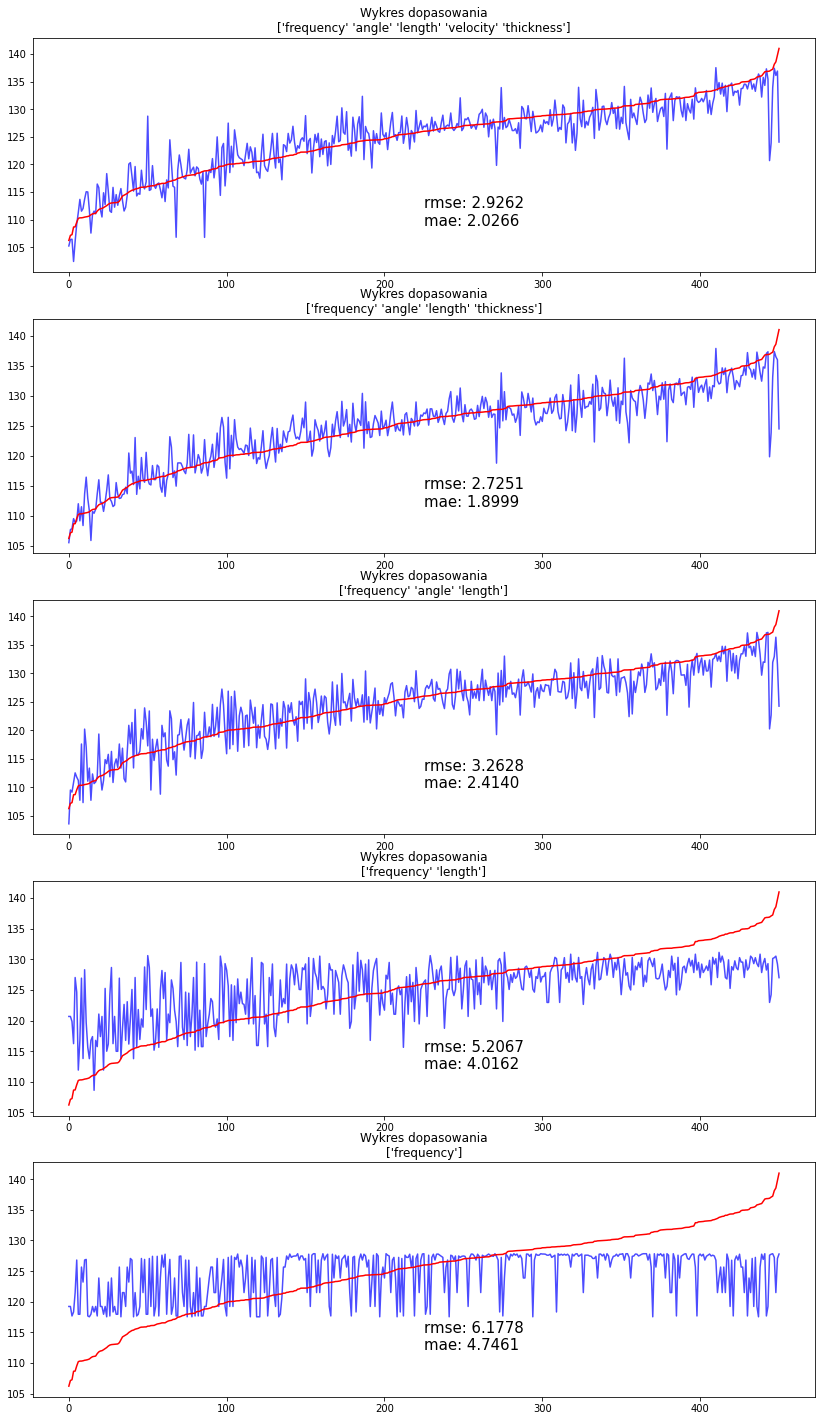

In [ ]:
# wykresy dla sobol 
evaluate_models(features_sobol, svm_models, model_builder=svm_builder(), amounts=1)